In [1]:
from __future__ import division
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import sparse as ssp
from sklearn.utils import resample,shuffle
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import lightgbm as lgb
import config
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn import preprocessing


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [71]:
RAW_PATH=config.RAW_PATH
FEAT_PATH =config.FEAT_PATH

train = pd.read_csv(RAW_PATH+'train.csv')
train.drop(train.index[[config.ab_dup_test]], inplace=True)
train.reset_index(drop=True, inplace=True)
train_y = train['is_duplicate'].values

In [4]:
feat_df = ['feat_ab.csv','feature_base_lemmer.csv','feature_vect_lemmer.csv','feat_158_stpf.csv']
# feat_df = ['feat_ab.csv','feat_158_stpf.csv']

df = pd.read_csv(FEAT_PATH+'magic_feature.csv')
del df['question1'], df['question2'], df['id']
print 'feat_mag {}'.format(df.shape)

def remove_col(train):
    list1=['question1','question2','id','is_duplicate']
    for i in list1:
        if i in list(train.columns):
            del train[i]
    return train

for f in feat_df:
    df1 = pd.read_csv(FEAT_PATH+f)
    df1 = remove_col(df1)
    df = pd.concat([df, df1],axis=1)
    del df1
    gc.collect()
    print f, df.shape

# feat_ab = pd.read_csv(FEAT_PATH+'feat_ab.csv')
# del feat_ab['question1'], feat_ab['question2']
# print 'feat_ab {}'.format(feat_ab.shape)

# feature_base_close_porter = pd.read_csv(FEAT_PATH+'feature_base_close_porter.csv')
# del feature_base_close_porter['question1'], feature_base_close_porter['question2'], feature_base_close_porter['is_duplicate']
# print 'feature_base_close_porter {}'.format(feature_base_close_porter.shape)

# df = pd.concat([feat_mag, feat_ab, feature_base_close_porter], axis=1)
# print 'df {}'.format(df.shape)

# del feat_mag, feat_ab, feature_base_close_porter
gc.collect()

feat_mag (2750086, 26)
feat_ab.csv (2750086, 55)
feature_base_lemmer.csv (2750086, 267)
feature_vect_lemmer.csv (2750086, 388)
feat_158_stpf.csv (2750086, 404)


0

In [5]:
del_feat = ['q1_hash','q2_hash','q_hash_pos','q_hash_pos_1','q1_change','q2_change']
del_feat.extend(['q_change_pair','q1_q2_change_max'])
del_feat.extend(['euclidean_distance', 'jaccard_distance','RMSE_distance'])
# del_feat.extend(['freq_diff', 'q1_q2_intersect_ratio'])
del_feat.extend(list(tr_corr[abs(tr_corr['is_duplicate'])<0.01].index))

print df.shape
for i in list(df.columns):
    if i in del_feat:
        del df[i]
# df = df[use_feat]
print df.shape

NameError: name 'tr_corr' is not defined

In [5]:
tr_corr = df[df['is_duplicate']!=-1].corr()
# tr_corr.sort_values(by='is_duplicate',ascending=0)
abs(tr_corr).sort_values(by='is_duplicate',ascending=0)
# tr_corr[abs(tr_corr['is_duplicate'])<0.1]
# tr_corr[tr_corr.index.str.contains('pos')].sort_values(by='is_duplicate',ascending=0)

,is_duplicate,q1_freq,q2_freq,freq_diff,q1_q2_intersect,q1_q2_intersect_ratio,q1_q2_wm_ratio,q1_pr,q2_pr,z_place_match,...,wc_diff_unique,wc_ratio_unique,wc_diff_unq_stop,wc_ratio_unique_stop,same_start,char_diff,char_diff_unq_stop,total_unique_words,total_unq_words_stop,char_ratio
is_duplicate,1.000000,0.296621,0.198609,0.337501,0.412979,0.609256,0.641026,0.018429,0.016661,0.063175,...,0.207048,0.065786,0.212901,0.066541,0.197812,0.211750,0.221244,0.288730,0.301078,0.044247
q1_q2_wm_ratio,0.641026,0.487466,0.355246,0.444353,0.684574,0.976114,1.000000,0.083618,0.034415,0.033779,...,0.151437,0.044734,0.152581,0.045589,0.120138,0.154682,0.157205,0.188936,0.202187,0.029748
q1_q2_intersect_ratio,0.609256,0.490514,0.358951,0.428979,0.722593,1.000000,0.976114,0.065419,0.024576,0.033451,...,0.147422,0.043581,0.148945,0.045619,0.114459,0.150171,0.152772,0.178367,0.191013,0.029460
word_match,0.456173,0.108091,0.068038,0.131844,0.164976,0.292098,0.289983,0.000107,0.010960,0.074797,...,0.416946,0.130007,0.423744,0.140251,0.365136,0.401727,0.421170,0.504688,0.514084,0.097808
tfidf_wm,0.426661,0.045062,0.013690,0.119178,0.097573,0.241715,0.240230,0.018761,0.029882,0.057995,...,0.389450,0.119110,0.390666,0.124922,0.310045,0.377316,0.394885,0.481146,0.492038,0.090539
tfidf_wm_stops,0.424446,0.046444,0.014802,0.119944,0.099261,0.241695,0.240182,0.018047,0.029574,0.057249,...,0.380831,0.116539,0.384502,0.123480,0.293581,0.370424,0.389616,0.475493,0.490034,0.088959
dicedistence_n1,0.420369,0.085192,0.042429,0.084832,0.120920,0.237792,0.245715,0.006209,0.018697,0.072514,...,0.449278,0.141261,0.460238,0.148549,0.370355,0.441570,0.463231,0.561132,0.564348,0.110338
q1_q2_intersect,0.412979,0.789134,0.591368,0.298225,1.000000,0.722593,0.684574,0.185699,0.095871,0.002180,...,0.086745,0.025830,0.086129,0.026942,0.069998,0.089146,0.088645,0.088004,0.094159,0.016798
jaccard_n1,0.403398,0.053339,0.023333,0.093114,0.093163,0.207972,0.212186,0.012013,0.020005,0.062210,...,0.431276,0.129653,0.444258,0.137975,0.357477,0.425794,0.449788,0.544192,0.546700,0.100936
compression_dist,0.401608,0.070227,0.044802,0.097175,0.109371,0.225148,0.231770,0.004483,0.003890,0.044859,...,0.591821,0.173829,0.629824,0.190559,0.377760,0.614931,0.658859,0.672904,0.682621,0.149767


In [7]:
####################################################
########### remove high related features ###########
####################################################

ab_corr = abs(tr_corr).sort_values(by='is_duplicate',ascending=0)
corr_list = list(ab_corr.index)
for i in list(ab_corr.index):
    if i in corr_list:
        for j in corr_list:
            if ab_corr.ix[i][j]>0.9 and ab_corr.ix[i][j]<1:
                corr_list.remove(j)
                print (i,j,ab_corr.ix[i][j])
    else: pass
    
# df = df[corr_list]
# print df.shape

('q1_q2_wm_ratio', 'q1_q2_intersect_ratio', 0.98339464560072498)
('word_match', 'tfidf_wm', 0.93322210026153851)
('tfidf_wm_stops', 'word_match', 0.92995158765309249)
('cosine_distance', 'braycurtis_distance', 0.97916062541974491)
('cosine_distance', 'RMSE_distance', 0.94831239762790553)
('cosine_distance', 'minkowski_distance', 0.94797559168818923)
('fuzz_token_sort_ratio', 'fuzz_qratio', 0.92026621176353296)
('fuzz_token_sort_ratio', 'fuzz_partial_token_sort_ratio', 0.91308422436086456)
('euclidean_distance', 'cosine_distance', 0.94831843891180545)
('euclidean_distance', 'cityblock_distance', 0.99935660679125382)
('euclidean_distance', 'canberra_distance', 0.9563974628318419)
('wmd', 'norm_wmd', 0.97716355153362222)
('total_unq_words_stop', 'total_unique_words', 0.95390582381940558)
('char_diff_unq_stop', 'wc_diff_unq_stop', 0.90138626802904287)
('char_diff', 'char_diff_unq_stop', 0.91877313594035004)
('char_diff', 'wc_diff_unique', 0.90408376051139294)
('wc_diff', 'char_diff', 0.923

In [5]:
#######################################
######### feature selection ###########
#######################################


train = df[df['is_duplicate']!=-1].copy()
train =train.replace([np.inf, -np.inf], np.nan).dropna()

# X_indices = np.arange(train.shape[-1])
# selector = SelectPercentile(f_classif, percentile=10)
# selector.fit(train, train['is_duplicate'])
# scores = -np.log10(selector.pvalues_)
# scores /= scores.max()
# plt.bar(X_indices - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

full_feat = list(train.columns)
full_feat.remove('is_duplicate')
min_max_scaler = preprocessing.MinMaxScaler()
train[full_feat] = min_max_scaler.fit_transform(train[full_feat])

selector = SelectKBest(chi2, k=350)
selector.fit(train[full_feat], train['is_duplicate'])
idxs_selected = selector.get_support(indices=True)
columns_selected = train[full_feat].columns[idxs_selected]
print columns_selected
del train
gc.collect()

# df = df[list(columns_selected)+['is_duplicate']]

Index([u'q1_freq', u'q2_freq', u'freq_diff', u'q1_q2_intersect',
       u'q1_q2_intersect_ratio', u'q1_q2_wm_ratio', u'q1_pr', u'q2_pr',
       u'z_place_match', u'z_place_match_num',
       ...
       u'wc_diff_unique', u'wc_ratio_unique', u'wc_diff_unq_stop',
       u'wc_ratio_unique_stop', u'same_start', u'char_diff',
       u'char_diff_unq_stop', u'total_unique_words', u'total_unq_words_stop',
       u'char_ratio'],
      dtype='object', length=350)


In [6]:
######### 0.8 oversample ###########
test = df[df['is_duplicate']==-1].copy()
del test['is_duplicate']
train = df[df['is_duplicate']!=-1].copy()
del train['is_duplicate']
print train.shape, test.shape

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.1, random_state=4242)

#UPDownSampling
pos_train = X_train[y_train == 1]
neg_train = X_train[y_train == 0]
X_train = pd.concat((neg_train, pos_train.iloc[:int(0.8*len(pos_train))], neg_train))
y_train = np.array([0] * neg_train.shape[0] + [1] * pos_train.iloc[:int(0.8*len(pos_train))].shape[0] + [0] * neg_train.shape[0])
print(np.mean(y_train))
del pos_train, neg_train

pos_test = X_test[y_test == 1]
neg_test = X_test[y_test == 0]
X_test = pd.concat((neg_test, pos_test.iloc[:int(0.8 * len(pos_test))], neg_test))
y_test = np.array([0] * neg_test.shape[0] + [1] * pos_test.iloc[:int(0.8 * len(pos_test))].shape[0] + [0] * neg_test.shape[0])
print(np.mean(y_test))
del pos_test, neg_test

(404290, 46) (2345796, 46)
0.189752932122
0.189234677675


In [22]:
def oversample(X_ot,y,p=0.173):
    raw_num = X_ot.shape[0]
    print "RAW shape: {} | Mean rate: {}".format(X_ot.shape[0], y.mean())
    pos_ot = X_ot[y==1]
    neg_ot = X_ot[y==0]
    #p = 0.165
    scale = ((pos_ot.shape[0]*1.0 / (pos_ot.shape[0] + neg_ot.shape[0])) / p) - 1
    while scale > 1:
        neg_ot = np.vstack([neg_ot, neg_ot])
        scale -=1
    neg_ot = np.vstack([neg_ot, neg_ot[:int(scale * neg_ot.shape[0])]])
    ot = np.vstack([pos_ot, neg_ot])
    y=np.zeros(ot.shape[0])
    y[:pos_ot.shape[0]]=1.0
    print "Oversample: {} | Mean rate: {}".format(ot.shape[0],y.mean())
    return ot,y


test = df[df['is_duplicate']==-1].copy()
del test['is_duplicate']
train = df[df['is_duplicate']!=-1].copy()
del train['is_duplicate']
del df
print train.shape, test.shape

############### drop absolute duplicate rows #################
train.drop(train.index[[config.ab_dup_test]], inplace=True)
train.reset_index(drop=True, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.1, random_state=1048)

X_train,y_train = oversample(X_train,y_train,p=0.1742)
X_test,y_test = oversample(X_test,y_test,p=0.1742)
X_train,y_train = shuffle(X_train,y_train,random_state=421)  
print X_train.shape, y_train.shape
gc.collect()

In [10]:
def xgb_train(n=2500,params=False):
    if not params:
        params = {}
        params['base_score'] = 0.2
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'logloss'
        params['eta'] = 0.02
        params['max_depth'] = 7
        params['subsample'] = 0.6
        params['nthread'] = 16
        # params['colsample_bytree'] = 0.6 
        # params['gamma'] = 0.1 
        # params['min_child_weight'] = 5
        # params['scale_pos_weight'] = 0.2
    print params

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, n, watchlist, early_stopping_rounds=50, verbose_eval=100)
    train_loss_str = log_loss(y_train, bst.predict(d_train))
    valid_loss_str = log_loss(y_test, bst.predict(d_valid))
    sub_stamp = 'xgb_t%s_v%s'%(str(train_loss_str)[2:6], str(valid_loss_str)[2:6])
    
    print 'train logloss: %s' %(train_loss_str)
    print 'valid logloss: %s' %(valid_loss_str)
    print 'best_ntree_limit %s' %(bst.best_ntree_limit)
    
    return bst, bst.best_ntree_limit, sub_stamp, params

In [11]:
params_opt = {'colsample_bytree': 0.7852290495822306, 'eval_metric': 'logloss', 'max_delta_step': 2.0, 'nthread': 16, 
          'min_child_weight': 3.0, 'subsample': 0.8071297738930207, 'base_score': 0.2, 
          'objective': 'binary:logistic', 'alpha': 10, 'max_depth': 11, 'gamma': 0.1, 'lambda': 100}
params_opt['eta'] = 0.02

bst, BEST_NTREE, sub_stamp, PARAMS = xgb_train(n=5000,params=params_opt)

bst.save_model(config.SUB_PATH + sub_stamp+'.mdl')
bst = xgb.Booster(PARAMS)
bst.load_model(config.SUB_PATH + sub_stamp+'.mdl')

d_test = xgb.DMatrix(test)
p_test = bst.predict(d_test, ntree_limit=BEST_NTREE)

sub = pd.DataFrame()
df_test = pd.read_csv(config.RAW_PATH+'test.csv')
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv(config.SUB_PATH + sub_stamp+'.csv', index=False)

del df_test
gc.collect()

{'eval_metric': 'logloss', 'max_delta_step': 2.0, 'base_score': 0.2, 'alpha': 10, 'colsample_bytree': 0.7852290495822306, 'nthread': 16, 'min_child_weight': 3.0, 'subsample': 0.8071297738930207, 'eta': 0.02, 'objective': 'binary:logistic', 'max_depth': 11, 'gamma': 0.1, 'lambda': 100}
[0]	train-logloss:0.50341	valid-logloss:0.50313
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.219269	valid-logloss:0.227403
[200]	train-logloss:0.18408	valid-logloss:0.196613
[300]	train-logloss:0.172434	valid-logloss:0.188292
[400]	train-logloss:0.164398	valid-logloss:0.184019
[500]	train-logloss:0.157704	valid-logloss:0.181411
[600]	train-logloss:0.151349	valid-logloss:0.17949
[700]	train-logloss:0.145556	valid-logloss:0.178007
[800]	train-logloss:0.140086	valid-logloss:0.176809
[900]	train-logloss:0.134905	valid-logloss:0.175897
[1000]	train-logloss:0.130165	valid-logloss:0.175

82

In [11]:
####### lightgbm ######

def lgb_train(params, n_inter=200):
    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_test, label=y_test)
    watchlist = [d_train, d_valid]
    bst = lgb.train(params, d_train, n_inter, watchlist, early_stopping_rounds=30, verbose_eval=100)
    train_loss_str = log_loss(y_train, bst.predict(X_train))
    valid_loss_str = log_loss(y_test, bst.predict(X_test))
    sub_stamp = 'lgb_t%s_v%s'%(str(train_loss_str)[2:6], str(valid_loss_str)[2:6])
    num_iteration=bst.best_iteration

    print 'train logloss: %s' %(train_loss_str)
    print 'valid logloss: %s' %(valid_loss_str)
    return bst, num_iteration, sub_stamp

params_lgb = {}
params_lgb['learning_rate'] = 0.05
params_lgb['boosting_type'] = 'dart'
params_lgb['objective'] = 'binary'
params_lgb['metric'] = 'binary_logloss'
params_lgb['feature_fraction'] = 0.7
params_lgb['bagging_fraction'] = 0.7
params_lgb['num_leaves'] = 256
params_lgb['max_depth'] = 8
params_lgb['min_data_in_leaf'] = 1
params_lgb['min_data'] = 50
params_lgb['min_hessian'] = 1
params_lgb['is_unbalance'] = True

bst, num_iteration, sub_stamp = lgb_train(params_lgb, n_inter=2000)
p_test = bst.predict(test, num_iteration=num_iteration)

sub = pd.DataFrame()
df_test = pd.read_csv(config.RAW_PATH+'test.csv')
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv(config.SUB_PATH + sub_stamp+'.csv', index=False)

del df_test
gc.collect()

# lgb.train(params, train_set, num_boost_round=100, valid_sets=None, valid_names=None, fobj=None, feval=None, 
#           init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, 
#           evals_result=None, verbose_eval=True, learning_rates=None, callbacks=None)

Train until valid scores didn't improve in 30 rounds.
[100]	training's binary_logloss: 0.258224	valid_1's binary_logloss: 0.283031
[200]	training's binary_logloss: 0.21013	valid_1's binary_logloss: 0.247885
[300]	training's binary_logloss: 0.180039	valid_1's binary_logloss: 0.231944
[400]	training's binary_logloss: 0.158238	valid_1's binary_logloss: 0.223963
[500]	training's binary_logloss: 0.14591	valid_1's binary_logloss: 0.220252
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.140657	valid_1's binary_logloss: 0.218957
train logloss: 0.146522590924
valid logloss: 0.220318533714


7

In [7]:
############# oof ############
def xgb_train(n=2500,params=False):
    if not params:
        params = {}
        params['base_score'] = 0.2
        params['objective'] = 'binary:logistic'
        params['eval_metric'] = 'logloss'
        params['eta'] = 0.02
        params['max_depth'] = 7
        params['subsample'] = 0.75
        params['nthread'] = 16
        params['colsample_bytree'] = 0.7 
        params['gamma'] = 0.1 
        params['min_child_weight'] = 3
        # params['scale_pos_weight'] = 0.2
        params['max_delta_step'] = 2

    print params

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, n, watchlist, early_stopping_rounds=50, verbose_eval=200)
    train_loss_str = log_loss(y_train, bst.predict(d_train))
    valid_loss_str = log_loss(y_test, bst.predict(d_valid))
    sub_stamp = 'xgb_t%s_v%s'%(str(train_loss_str)[2:6], str(valid_loss_str)[2:6])
    print sub_stamp
    print 'train logloss: %s' %(train_loss_str)
    print 'valid logloss: %s' %(valid_loss_str)
    print 'best_ntree_limit: %s' %(bst.best_ntree_limit)
    oof_valid = bst.predict(d_valid, ntree_limit = bst.best_ntree_limit)
    return bst, bst.best_ntree_limit, sub_stamp, params, oof_valid


# random_seed = config.oof_random
random_seed = 1988


test_array = np.zeros(test.shape[0],dtype='float32')
oof_array = []

kf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for train_idx, valid_idx in kf.split(train, y=train_y):
    X_train, X_test, y_train, y_test = train.loc[train_idx,:], train.loc[valid_idx,:], train_y[train_idx],train_y[valid_idx]
    print X_train.shape, y_train.shape
    X_train,y_train = oversample(X_train,y_train,p=0.1742)
    X_test,y_test = oversample(X_test,y_test,p=0.1742)
    X_train,y_train = shuffle(X_train,y_train,random_state=42)  
    print X_train.shape, y_train.shape
    bst, best_ntree_limit, sub_stamp, params, oof_valid = xgb_train(n=3000)
    oof_array.extend(list(oof_valid))
    
    bst.save_model(config.SUB_PATH + sub_stamp+'_oof'+'.mdl')
    bst = xgb.Booster(params)
    bst.load_model(config.SUB_PATH + sub_stamp+'_oof'+'.mdl')
    d_test = xgb.DMatrix(test)
    p_test = bst.predict(d_test, ntree_limit = best_ntree_limit)
    test_array = test_array + p_test
    print '='*20

test_array = test_array / 5.0
sub = pd.DataFrame()
df_test = pd.read_csv(config.RAW_PATH+'test.csv')
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = test_array
sub.to_csv(config.SUB_PATH + 'oof_xgb_test.csv',index=False)

sub = pd.DataFrame()
sub['xgb'] = oof_array
sub.to_csv(config.SUB_PATH + 'oof_xgb_valid.csv',index=False)


del df_test
gc.collect()

(323402, 403) (323402,)
RAW shape: 323402 | Mean rate: 0.369230864373
Oversample: 576180 | Mean rate: 0.207244263945
RAW shape: 80852 | Mean rate: 0.369230198387
Oversample: 144047 | Mean rate: 0.207244857581
(576180, 403) (576180,)
{'colsample_bytree': 0.7, 'eval_metric': 'logloss', 'max_delta_step': 2, 'nthread': 16, 'base_score': 0.2, 'subsample': 0.75, 'eta': 0.02, 'min_child_weight': 3, 'objective': 'binary:logistic', 'max_depth': 7, 'gamma': 0.1}
[0]	train-logloss:0.503596	valid-logloss:0.50362
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[200]	train-logloss:0.189948	valid-logloss:0.196425
[400]	train-logloss:0.170875	valid-logloss:0.183451
[600]	train-logloss:0.159765	valid-logloss:0.178592
[800]	train-logloss:0.151321	valid-logloss:0.176105
[1000]	train-logloss:0.144417	valid-logloss:0.174563
[1200]	train-logloss:0.138119	valid-logloss:0.173543
[1400]	train-logloss:0.132505

154

In [40]:
###################################################
############### train on full dataset #############
###################################################

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2, random_state=1024)

X_train,y_train = oversample(X_train,y_train,p=0.173)
X_test,y_test = oversample(X_test,y_test,p=0.173)

X_train = np.concatenate((X_train, X_test), axis=0)#.shape
y_train = np.concatenate((y_train, y_test), axis=0)#.shape

X_train,y_train = shuffle(X_train,y_train,random_state=42)  
print X_train.shape, y_train.shape

d_train = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(params, d_train, 500, verbose_eval=30)
print(log_loss(y_test, bst.predict(d_valid)))

RAW shape: 323432 | Mean rate: 0.368924534369
Oversample: 581635 | Mean rate: 0.205149277468
RAW shape: 80858 | Mean rate: 0.370291127656
Oversample: 146073 | Mean rate: 0.204972856038
(727708, 207) (727708,)
0.185475337464


Features: 393
Features importances...


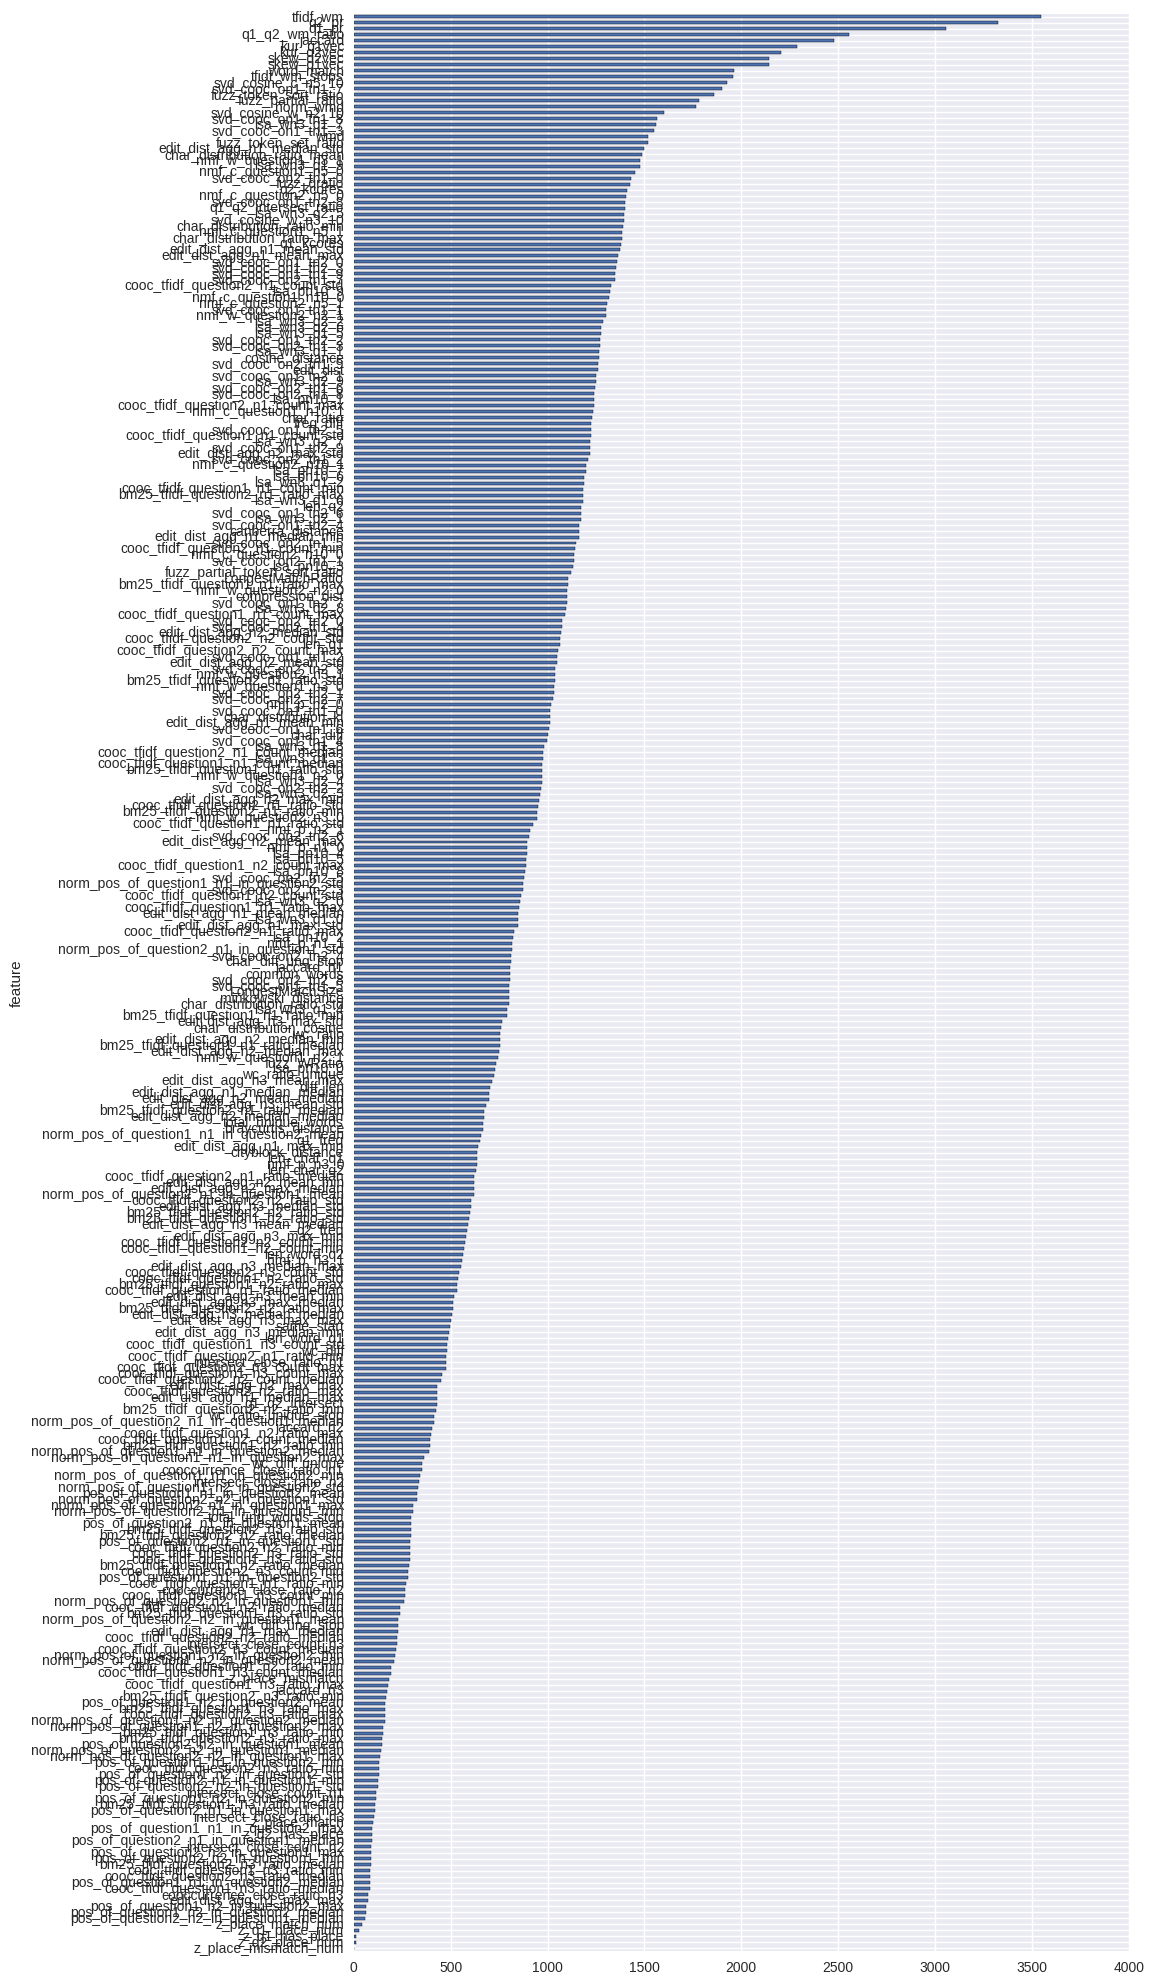

In [9]:
features = list(train.columns.values)
print("Features: {}".format(len(features)))
print("Features importances...")
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
# ft.index = ft.reset_index()['index'].map(mapFeat)

ft = pd.Series(bst.get_fscore())

ft = pd.DataFrame(ft).reset_index().rename(columns={'index': 'feature',0:"fscore"}).sort_values(by='fscore',ascending=1)
# ft['feature'] = ft['feature'].map(mapFeat)
ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))

Features: 33
Features importances...


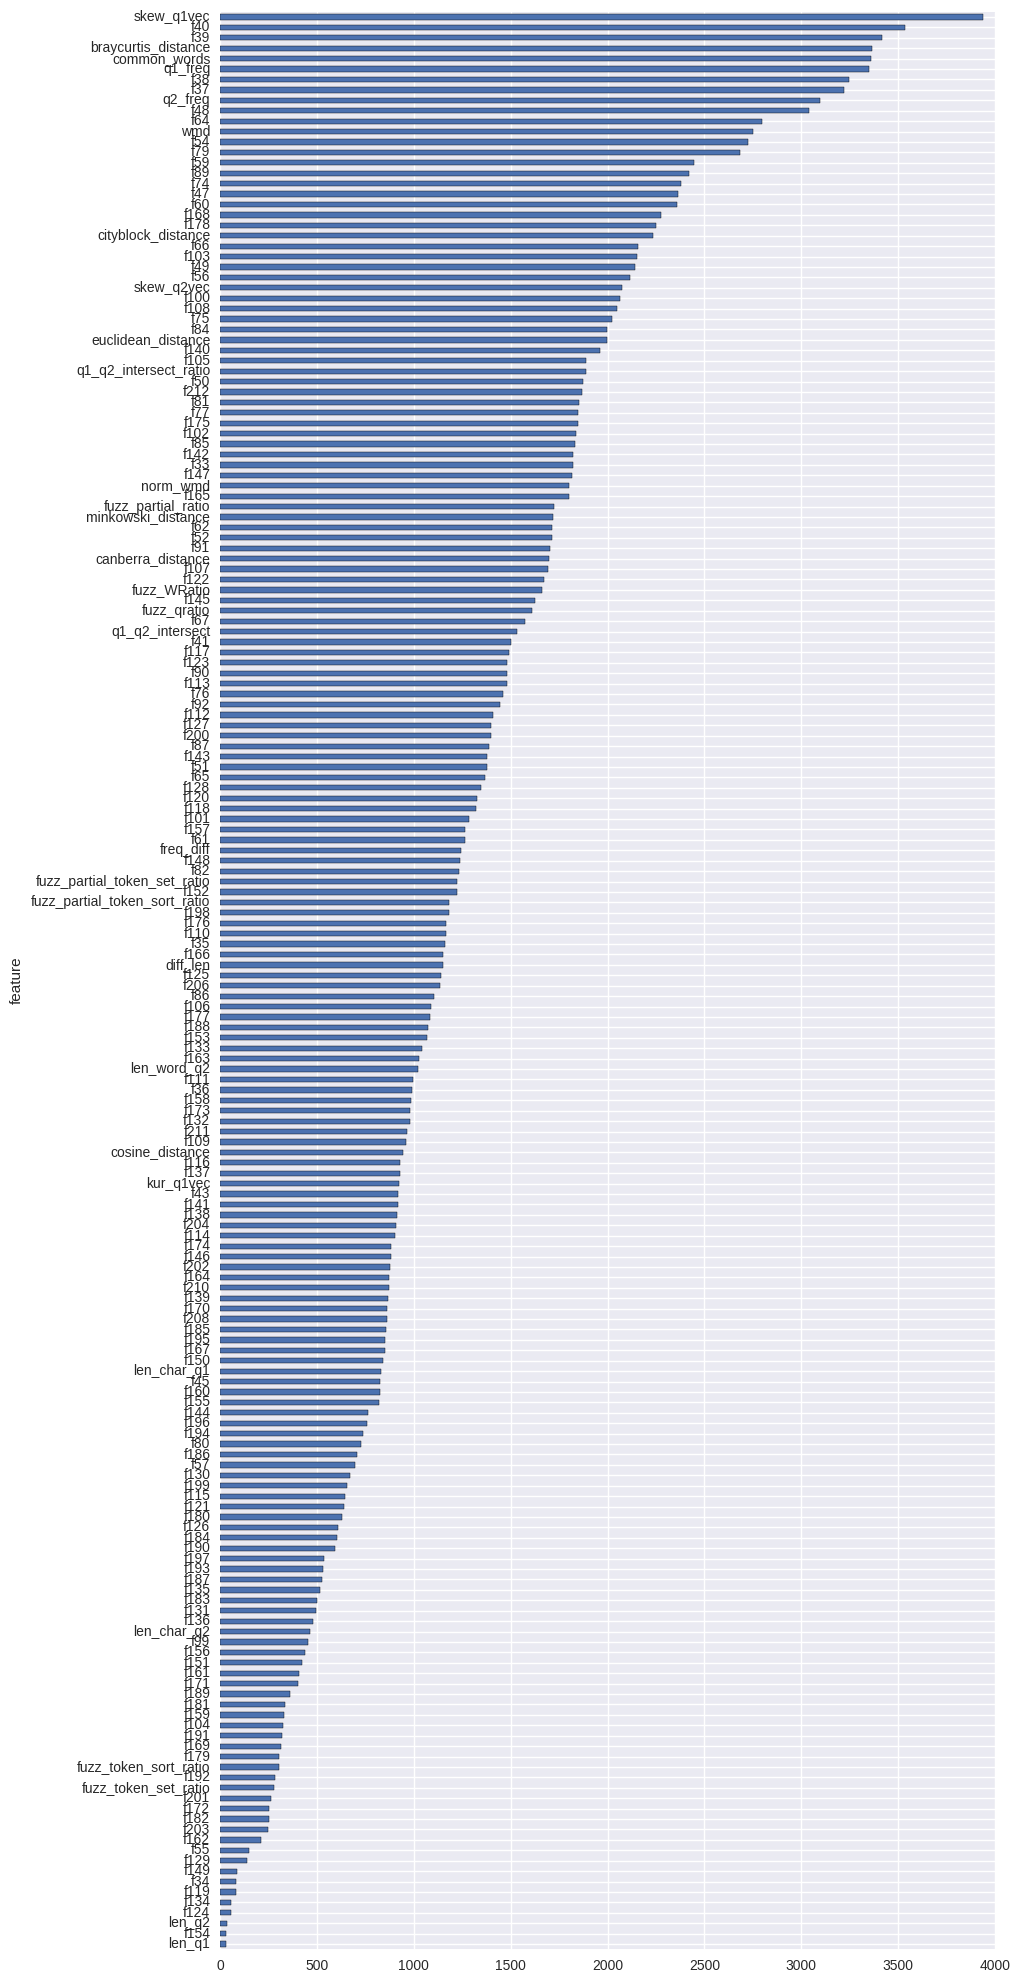

In [99]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

feature_names = list(train.columns.values)
create_feature_map(feature_names)
print("Features: {}".format(len(feature_names)))
print("Features importances...")
import operator
importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))

In [24]:
ft_corr = tr_corr.reset_index()
ft_corr = ft_corr.rename(columns={'index': 'feature'})[['feature','is_duplicate']]
ft_corr = ft_corr.merge(ft,how='left')
ft_corr.sort_values(by='fscore',ascending=0)

,feature,is_duplicate,fscore
22,common_words,0.232293,1537.0
31,norm_wmd,-0.350185,1444.0
14,q1_q2_wm_ratio,0.645999,1148.0
13,q1_q2_intersect_ratio,0.610168,1106.0
30,wmd,-0.357621,1073.0
51,edit_dist,-0.335208,938.0
5,freq_diff,-0.332427,816.0
28,fuzz_token_set_ratio,0.396250,806.0
25,fuzz_partial_ratio,0.358234,802.0
12,q1_q2_intersect,0.432860,706.0


In [ ]:
{'colsample_bytree': 0.7852290495822306, 'eval_metric': 'logloss', 'max_delta_step': 2.0, 'nthread': 16, 'min_child_weight': 3.0, 'subsample': 0.8071297738930207, 'eta': 0.1, 'base_score': 0.2, 'objective': 'binary:logistic', 'alpha': 10, 'max_depth': 11, 'gamma': 0.1, 'lambda': 100}

In [8]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

def objective(space):
    params = {}    
    params['max_depth'] = int(space['max_depth'])
    params['subsample'] = space['subsample']
    params['colsample_bytree'] = space['colsample_bytree'] 
    params['gamma'] = space['gamma']
    params['lambda'] = space['lambda']
    params['alpha'] = space['alpha']
    params['min_child_weight'] = space['min_child_weight']
    params['max_delta_step'] = space['max_delta_step']
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.1
    params['nthread'] = 16
    params['base_score'] = 0.2
    print params
#     params['scale_pos_weight'] = 0.2
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=30, verbose_eval=500)
    logloss = log_loss(y_test, bst.predict(d_valid))

    return{'loss':logloss, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("max_depth", 4, 15, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.1, 0.9),
        'colsample_bytree':hp.uniform('colsample_bytree',0.1,0.9),
         'lambda':hp.choice('lambda',[1e-5, 1e-2, 0.05, 0.1, 1, 10, 100]),
         'alpha':hp.choice('alpha',[0, 0.001, 0.005, 0.01, 0.05,0.1,1,10]),
        'gamma':hp.choice('gamma',[0, 0.1,0.2,0.3,0.4,0.5]),
        'max_delta_step':hp.quniform('max_delta_step', 1, 10, 1)
        }
    

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print best

{'colsample_bytree': 0.6215866306140633, 'eval_metric': 'logloss', 'max_delta_step': 9.0, 'nthread': 16, 'min_child_weight': 5.0, 'subsample': 0.2046354209730657, 'eta': 0.1, 'base_score': 0.2, 'objective': 'binary:logistic', 'alpha': 0.001, 'max_depth': 4, 'gamma': 0.4, 'lambda': 10}
[0]	train-logloss:0.457755	valid-logloss:0.458087
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[500]	train-logloss:0.169888	valid-logloss:0.183592
Stopping. Best iteration:
[839]	train-logloss:0.160773	valid-logloss:0.181412

{'colsample_bytree': 0.4942310527676672, 'eval_metric': 'logloss', 'max_delta_step': 8.0, 'nthread': 16, 'min_child_weight': 8.0, 'subsample': 0.6688748954090619, 'eta': 0.1, 'base_score': 0.2, 'objective': 'binary:logistic', 'alpha': 0.005, 'max_depth': 7, 'gamma': 0, 'lambda': 0.1}
[0]	train-logloss:0.452926	valid-logloss:0.4535
Multiple eval metrics have been passed: 'valid-lo

KeyboardInterrupt: 